# utilizzo di più istanze sugli algoritmi di clustering


## **Definizione delle funzioni e classi:**



In [131]:
# Libreries
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
from collections import defaultdict
import itertools
import time,random

# Louvain


In [132]:
def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

    
def divide_into_clusters(graph):
    partition = community_louvain.best_partition(graph)
    clusters = defaultdict(list)
    for node, cluster_index in partition.items():
        clusters[cluster_index].append(node)
    return list(clusters.values())

def divide_into_clusters_fixed_k(graph, k):
    # Get the initial division into clusters
    clusters = divide_into_clusters(graph)

    # If there are already k clusters, return them
    if len(clusters) == k:
        return clusters

    # If there are more than k clusters, combine the smallest ones
    if len(clusters) > k:
        while len(clusters) > k:
            # Find the smallest cluster
            smallest_cluster = min(clusters, key=len)
            clusters.remove(smallest_cluster)
            # Find the cluster with which the smallest one shares the most edges
            max_shared_edges = 0
            for cluster in clusters:
                shared_edges = sum(1 for node in smallest_cluster if set(graph.neighbors(node)) & set(cluster))
                if shared_edges > max_shared_edges:
                    max_shared_edges = shared_edges
                    best_cluster_to_combine = cluster
            # Combine the clusters
            best_cluster_to_combine.extend(smallest_cluster)
        return clusters

    # If there are less than k clusters, split the largest ones
    if len(clusters) < k:
        while len(clusters) < k:
            # Find the largest cluster
            largest_cluster = max(clusters, key=len)
            clusters.remove(largest_cluster)
            # Find the node with the most connections outside the cluster
            max_external_connections = 0
            for node in largest_cluster:
                external_connections = sum(1 for neighbor in graph.neighbors(node) if neighbor not in largest_cluster)
                if external_connections > max_external_connections:
                    max_external_connections = external_connections
                    best_node_to_move = node
            # Create a new cluster with this node
            new_cluster = [best_node_to_move]
            largest_cluster.remove(best_node_to_move)
            # Move the nodes connected to the new cluster's node from the old cluster to the new one
            for node in list(largest_cluster):  # Copy the list to avoid problems while removing elements
                if best_node_to_move in graph.neighbors(node):
                    new_cluster.append(node)
                    largest_cluster.remove(node)
            # Add the modified and new clusters
            clusters.append(largest_cluster)
            clusters.append(new_cluster)
        return clusters


def calculate_multicut_size(graph, clusters):
    multicut_size = 0
    for cluster in clusters:
        for node in cluster:
            for neighbor in graph.neighbors(node):
                if neighbor not in cluster:
                    multicut_size += 1
    # Poiché ogni arco viene contato due volte (una volta per ogni estremo), dividi per 2
    return multicut_size // 2

def check_solution(graph, clusters):
    total_nodes = sum(len(cluster) for cluster in clusters)
    if total_nodes != graph.number_of_nodes():
        print("Ogni nodo deve essere in un solo cluster.")
        return False

    for cluster in clusters:
        for node in cluster:
            node_neighbors = set(graph.neighbors(node))
            cluster_set = set(cluster)
            if not node_neighbors & cluster_set:
                print("Ogni nodo deve essere collegato in qualche modo ad un altro nodo del cluster.")
                return False

    multicut_size = calculate_multicut_size(graph, clusters)
    print("Dimensione del multi-cut:", multicut_size)

    print("La soluzione è ammissibile.")
    return True

In [133]:
def divide_into_clusters_greedy(graph, k):
    nodes = list(graph.nodes())
    clusters = [[node] for node in nodes]

    # Continua a unire i cluster finché non raggiungi il numero di cluster desiderato
    while len(clusters) > k:
        min_multicut_size = float('inf')
        cluster_to_merge_index = -1

        # Per ogni coppia di cluster, calcola la taglia del multicut se fossero uniti
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                new_cluster = clusters[i] + clusters[j]
                new_multicut_size = calcola_dimensione_multicut(graph, clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:])

                # Se unire questi due cluster produce la taglia di multicut più piccola finora, tieni traccia di essi
                if new_multicut_size < min_multicut_size:
                    min_multicut_size = new_multicut_size
                    cluster_to_merge_index = (i, j)

        # Unisci i due cluster che producono la taglia di multicut più piccola
        i, j = cluster_to_merge_index
        new_cluster = clusters[i] + clusters[j]
        clusters = clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:]

    return clusters

def è_ammissibile(grafo, clusters):
    for cluster in clusters:
        sottografo = grafo.subgraph(cluster)
        if not nx.is_connected(sottografo):
            return False
    return True

def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if any(u in cluster and v in cluster for cluster in clusters):
            continue
        dimensione_multicut += 1  # o usa `grafo.edges[u, v]['weight']` se il grafo è pesato
    return dimensione_multicut

# Algoritmi genetici

Utilizzare gli algoritmi genetici (GA) per risolvere il problema di clustering può richiedere alcune decisioni di design:

- Codifica: come rappresentare una soluzione come un individuo in una popolazione.
- Funzione di fitness: come valutare la bontà di una soluzione.
- Selezione: come selezionare gli individui per la riproduzione.
- Crossover (ricombinazione): come combinare due individui per produrre un nuovo individuo.
- Mutazione: come introdurre piccole variazioni in un individuo.
  
Riorganizzando il codice per utilizzare gli algoritmi genetici:

- Codifica: ogni individuo è una lista di lunghezza uguale al numero di nodi nel grafo, dove l'elemento i-esimo rappresenta l'ID del cluster per il nodo i.

- Funzione di fitness: la funzione di fitness può essere basata sulla dimensione del multicut. Valori più bassi sono migliori.

- Selezione: utilizziamo la selezione della ruota della roulette.

- Crossover: utilizziamo un crossover a punto singolo.

- Mutazione: cambiamo l'ID del cluster di un nodo in modo casuale.

In [134]:
import random
def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if any(u in cluster and v in cluster for cluster in clusters):
            continue
        dimensione_multicut += 1  # o usa `grafo.edges[u, v]['weight']` se il grafo è pesato
    return dimensione_multicut
def init_population(size, num_nodes, k):
    return [[random.randint(0, k-1) for _ in range(num_nodes)] for _ in range(size)]

def fitness(individual, graph):
    clusters = [[] for _ in range(max(individual) + 1)]
    for i, cluster_id in enumerate(individual):
        clusters[cluster_id].append(i)
    return calcola_dimensione_multicut(graph, clusters)

def roulette_wheel_selection(population, fitness_values):
    total_fit = sum(fitness_values)
    pick = random.uniform(0, total_fit)
    current = 0
    for ind, fit in zip(population, fitness_values):
        current += fit
        if current > pick:
            return ind


def crossover(parent1, parent2):
    idx = random.randint(0, len(parent1) - 1)
    child1 = parent1[:idx] + parent2[idx:]
    child2 = parent2[:idx] + parent1[idx:]
    return child1, child2

def mutate(individual, k):
    idx = random.randint(0, len(individual) - 1)
    individual[idx] = random.randint(0, k-1)

def genetic_algorithm(graph, k, pop_size=100, gen_count=1000, mutation_rate=0.01):
  
    # 1. Prima inizializza la popolazione
    population = init_population(pop_size, len(graph.nodes()), k)

    # 2. Poi calcola i fitness_values per questa popolazione iniziale
    fitness_values = [fitness(ind, graph) for ind in population]

    for gen in range(gen_count):
        new_population = []
        while len(new_population) < pop_size:
            parent1 = roulette_wheel_selection(population, fitness_values)
            parent2 = roulette_wheel_selection(population, fitness_values)
            child1, child2 = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                mutate(child1, k)
            if random.random() < mutation_rate:
                mutate(child2, k)
            new_population.extend([child1, child2])
        population = new_population
    
    best_individual = min(population, key=lambda ind: fitness(ind, graph))
    clusters = [[] for _ in range(max(best_individual) + 1)]
    for i, cluster_id in enumerate(best_individual):
        clusters[cluster_id].append(i)
    return clusters

# Greedy con Ricerca Locale


In [135]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

""" def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G """

    
    

def divide_into_clusters_greedy(graph, k):
    nodes = list(graph.nodes())
    clusters = [[node] for node in nodes]

    # Continua a unire i cluster finché non raggiungi il numero di cluster desiderato
    while len(clusters) > k:
        min_multicut_size = float('inf')
        cluster_to_merge_index = (-1, -1)

        # Per ogni coppia di cluster, calcola la taglia del multicut se fossero uniti
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                new_cluster = clusters[i] + clusters[j]
                temp_clusters = clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:]
                new_multicut_size = calcola_dimensione_multicut(graph, temp_clusters)

                # Se unire questi due cluster produce la taglia di multicut più piccola finora, tieni traccia di essi
                if new_multicut_size < min_multicut_size and nx.is_connected(graph.subgraph(new_cluster)):
                    min_multicut_size = new_multicut_size
                    cluster_to_merge_index = (i, j)

        # Se non abbiamo trovato una coppia valida di cluster da unire, interrompiamo il ciclo
        if cluster_to_merge_index == (-1, -1):
            break

        # Unisci i due cluster che producono la taglia di multicut più piccola
        i, j = cluster_to_merge_index
        new_cluster = clusters[i] + clusters[j]
        clusters = clusters[:i] + [new_cluster] + clusters[i+1:j] + clusters[j+1:]

    return clusters


# Questa funzione verifica che ogni coppia di nodi in un cluster abbia un percorso nel grafo originale, 
# il che garantisce che il cluster sia una componente connessa del grafo originale.
def è_ammissibile(grafo, clusters):
    for cluster in clusters:
        for u, v in itertools.combinations(cluster, 2):
            if not nx.has_path(grafo, u, v):
                return False
    return True


def calcola_dimensione_multicut(grafo, clusters):
    dimensione_multicut = 0
    for u, v in grafo.edges():
        if any(u in cluster and v in cluster for cluster in clusters):
            continue
        dimensione_multicut += 1  # o usa `grafo.edges[u, v]['weight']` se il grafo è pesato
    return dimensione_multicut


def ricerca_locale(grafo, clusters):
    miglioramento = True

    while miglioramento:
        miglioramento = False

        for i, cluster in enumerate(clusters):
            for node in cluster:
                for j, target_cluster in enumerate(clusters):
                    if i != j:
                        # Prova a spostare il nodo al cluster target e verifica se migliora la dimensione del multicut
                        nuovo_clusters = [c[:] for c in clusters]
                        nuovo_clusters[i].remove(node)
                        nuovo_clusters[j].append(node)
                        
                        if calcola_dimensione_multicut(grafo, nuovo_clusters) < calcola_dimensione_multicut(grafo, clusters):
                            clusters = nuovo_clusters
                            miglioramento = True
                            break

                if miglioramento:
                    break

            if miglioramento:
                break

    return clusters


## **Codice principale**

In [136]:
""" def generate_random_graph(n, p):

    Genera un grafo casuale con n nodi e probabilità p di creare un arco.
    
    grafo = Graph()
    for i in range(n):
        grafo.aggiungi_vertice(i)

    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < p:
                grafo.aggiungi_arco(i, j)
    return grafo



if __name__ == "__main__":
    random_graph = generate_random_graph(15, 0.3)
    G = converti_grafo_personalizzato_in_networkx(random_graph)

    plt.figure(figsize=(10, 5))

    # Visualizza il grafo iniziale
    plot_graph(G, "Grafo Iniziale",121)

    k = 4
    start_time = time.time()
    clusters = divide_into_clusters(G, k) # Presumibilmente, divide_into_clusters è un algoritmo di Louvain
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Tempo di esecuzione dell'algoritmo di Louvain: {elapsed_time} secondi.")
    
    start_time = time.time()
    clusters_genetic = genetic_algorithm(G, k)
    end_time = time.time()
    elapsed_time_genetic = end_time - start_time
    print(f"Tempo di esecuzione dell'algoritmo genetico: {elapsed_time_genetic} secondi.")

    plot_graph(G, "Clustered Grafo with Genetic Algorithm", 122, colors=clusters_genetic)

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    plt.figure(figsize=(20, 15))
    
    # Visualizza il grafo iniziale
    plot_graph(G, "Grafo Iniziale", 131)

    # Utilizza l'algoritmo Greedy
    clusters_greedy = divide_into_clusters_greedy(G, 4)
    plot_graph(G, "Clustered with Greedy Algorithm", 132, colors=clusters_greedy)

    # Utilizza l'algoritmo Genetico (già fatto in precedenza)
    plot_graph(G, "Clustered with Genetic Algorithm", 133, colors=clusters_genetic)

    plt.tight_layout()
    plt.savefig("comparison.png")
    plt.show() """

' def generate_random_graph(n, p):\n\n    Genera un grafo casuale con n nodi e probabilità p di creare un arco.\n    \n    grafo = Graph()\n    for i in range(n):\n        grafo.aggiungi_vertice(i)\n\n    for i in range(n):\n        for j in range(i + 1, n):\n            if random.random() < p:\n                grafo.aggiungi_arco(i, j)\n    return grafo\n\n\n\nif __name__ == "__main__":\n    random_graph = generate_random_graph(15, 0.3)\n    G = converti_grafo_personalizzato_in_networkx(random_graph)\n\n    plt.figure(figsize=(10, 5))\n\n    # Visualizza il grafo iniziale\n    plot_graph(G, "Grafo Iniziale",121)\n\n    k = 4\n    start_time = time.time()\n    clusters = divide_into_clusters(G, k) # Presumibilmente, divide_into_clusters è un algoritmo di Louvain\n    end_time = time.time()\n    elapsed_time = end_time - start_time\n    print(f"Tempo di esecuzione dell\'algoritmo di Louvain: {elapsed_time} secondi.")\n    \n    start_time = time.time()\n    clusters_genetic = genetic_al

# istanze

In [137]:
""" def genera_istanze(n_istanze=20):
    istanze = []
    for _ in range(n_istanze):
        n = random.randint(5, 20)  # Numero di nodi tra 5 e 50
        p = random.uniform(0.05, 0.55)  # Probabilità di un arco tra due nodi
        G = nx.erdos_renyi_graph(n, p, seed=42)
        istanze.append(G)
    return istanze """

' def genera_istanze(n_istanze=20):\n    istanze = []\n    for _ in range(n_istanze):\n        n = random.randint(5, 20)  # Numero di nodi tra 5 e 50\n        p = random.uniform(0.05, 0.55)  # Probabilità di un arco tra due nodi\n        G = nx.erdos_renyi_graph(n, p, seed=42)\n        istanze.append(G)\n    return istanze '

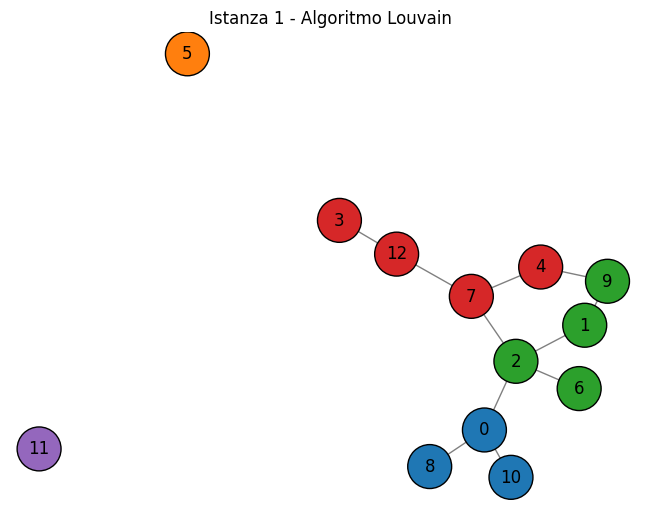

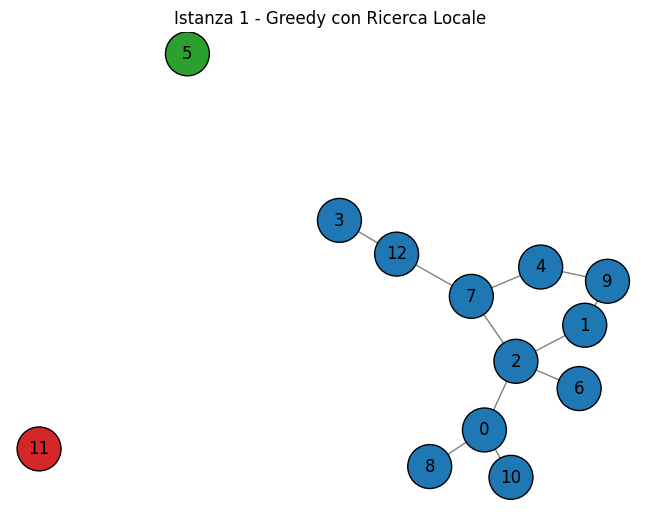

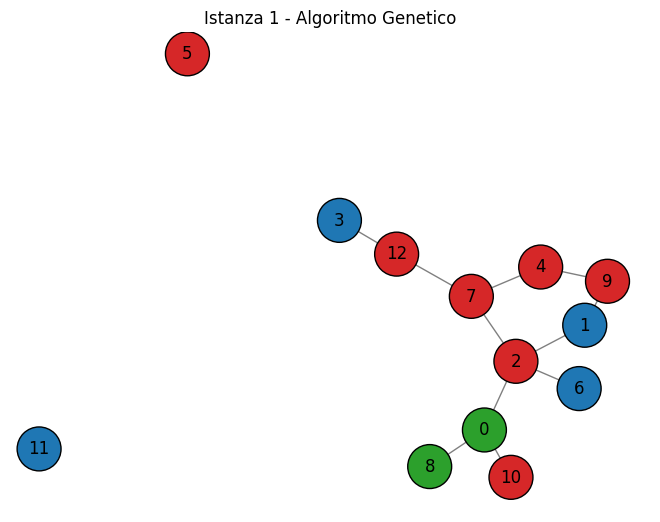

Istanza 1:
  - Tempo di esecuzione Louvain: 0.0009 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0140 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.6910 secondi


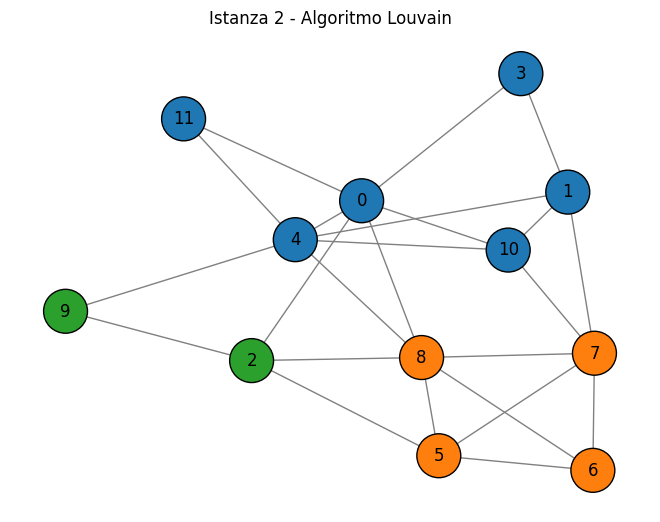

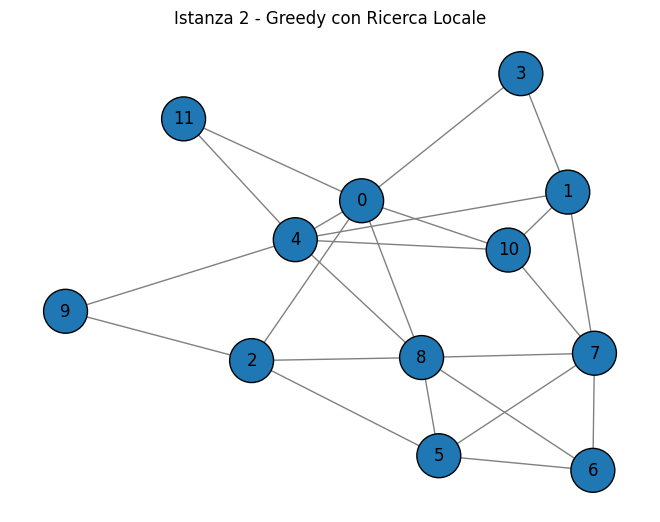

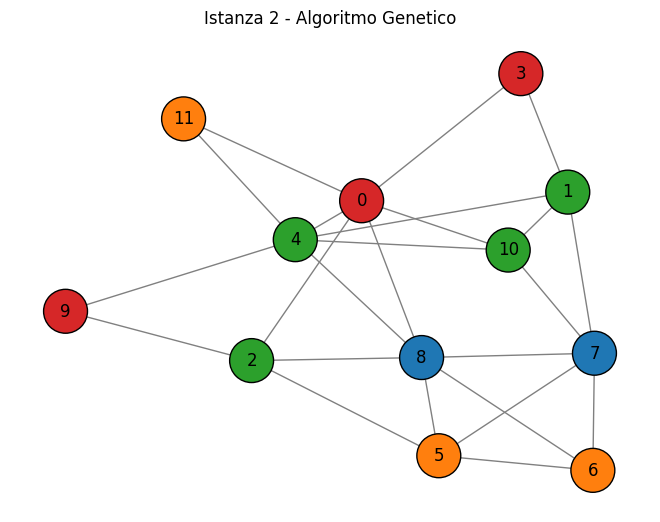

Istanza 2:
  - Tempo di esecuzione Louvain: 0.0010 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0169 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7038 secondi


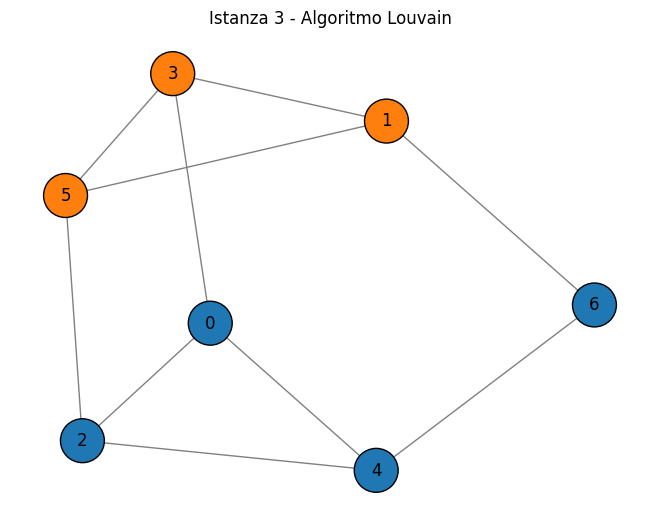

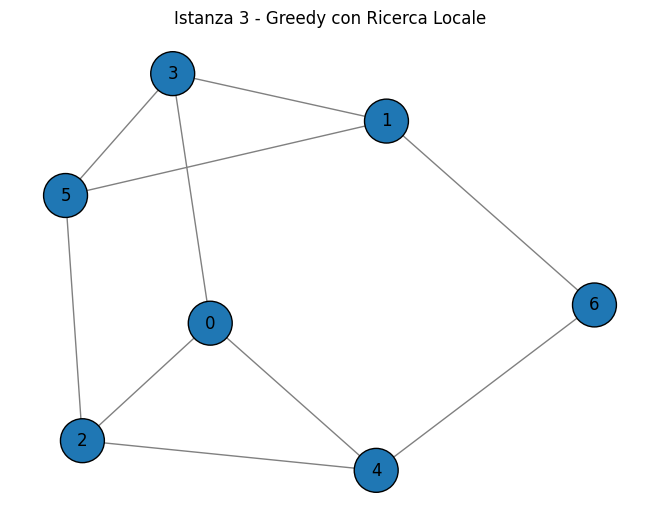

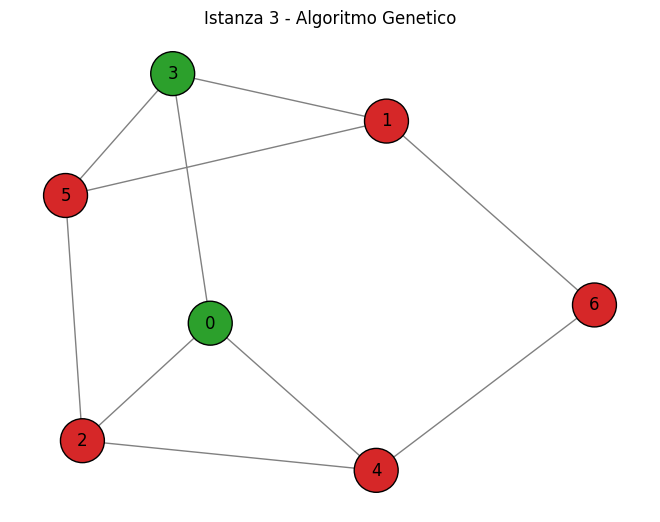

Istanza 3:
  - Tempo di esecuzione Louvain: 0.0005 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0025 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7101 secondi


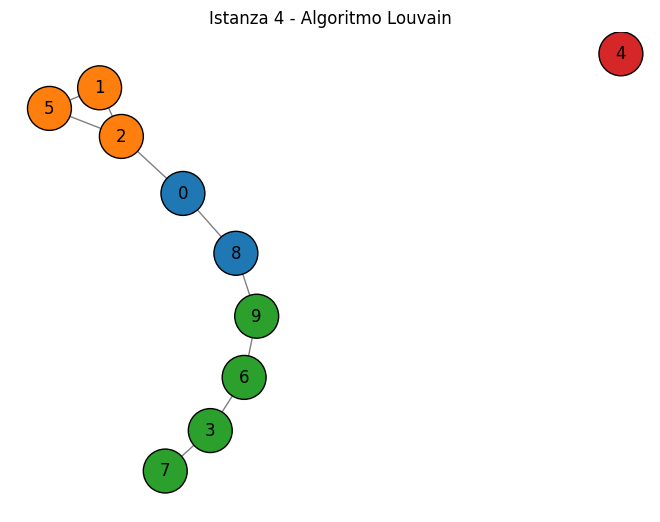

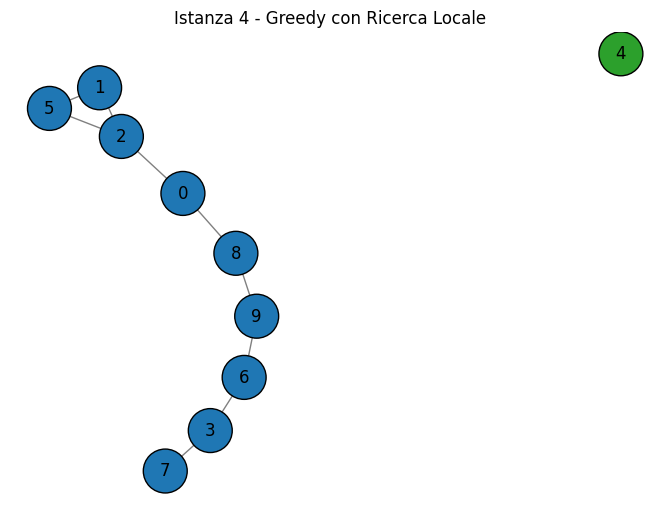

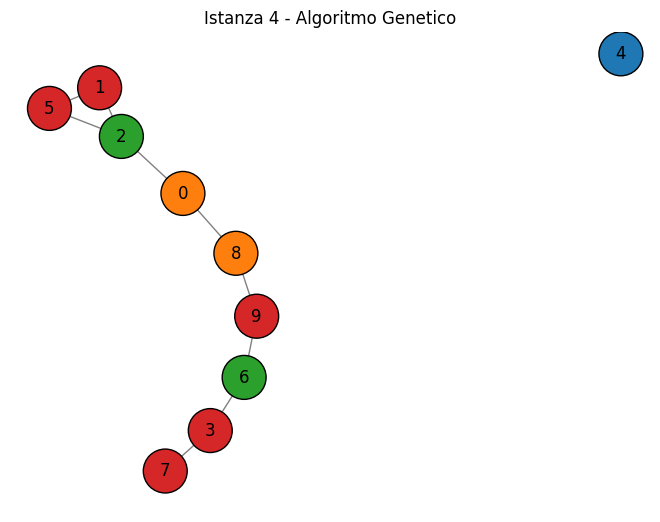

Istanza 4:
  - Tempo di esecuzione Louvain: 0.0007 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0049 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.6733 secondi


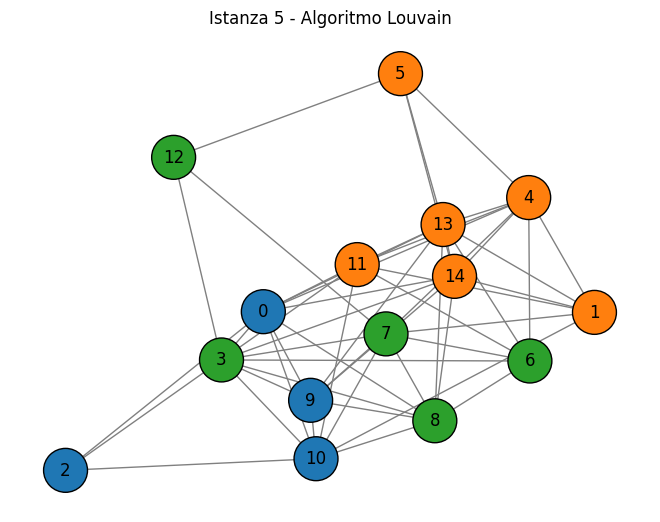

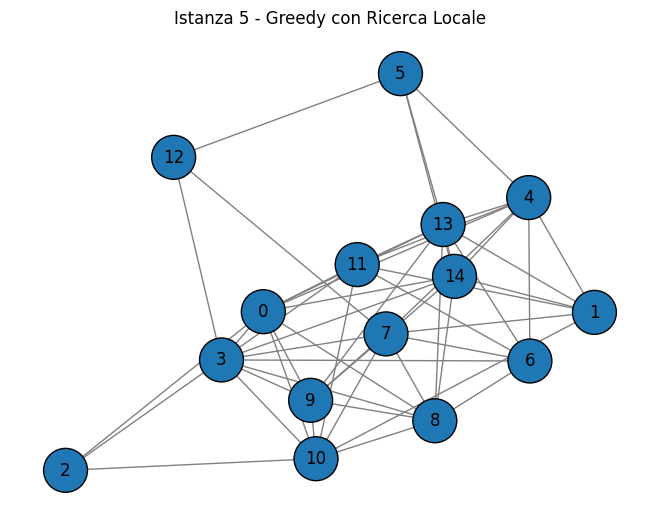

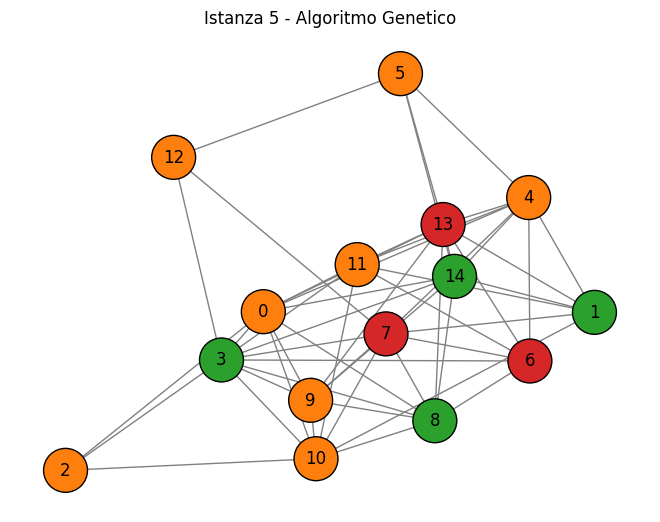

Istanza 5:
  - Tempo di esecuzione Louvain: 0.0014 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0594 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7195 secondi


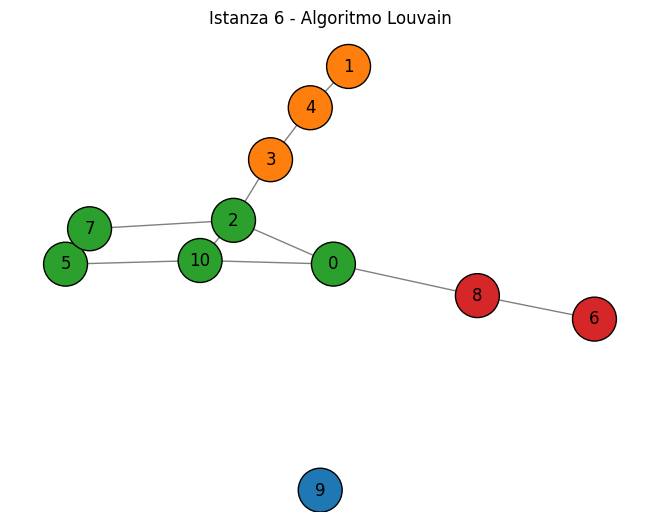

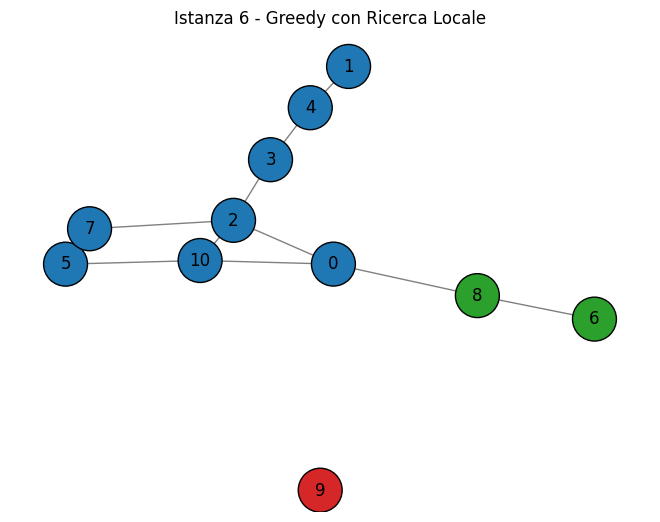

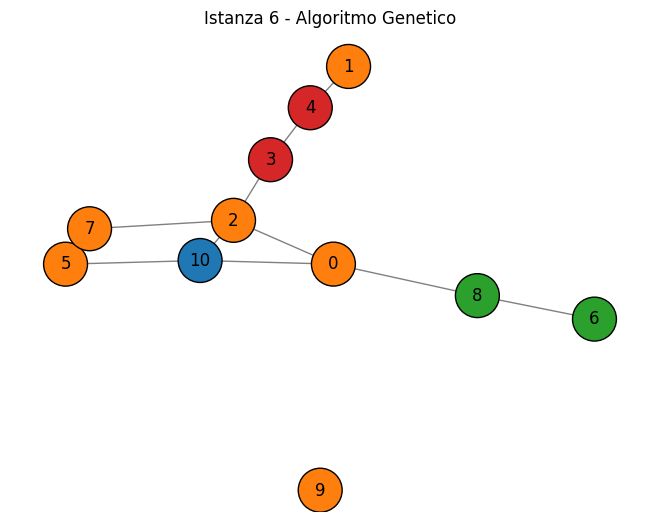

Istanza 6:
  - Tempo di esecuzione Louvain: 0.0009 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0058 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7451 secondi


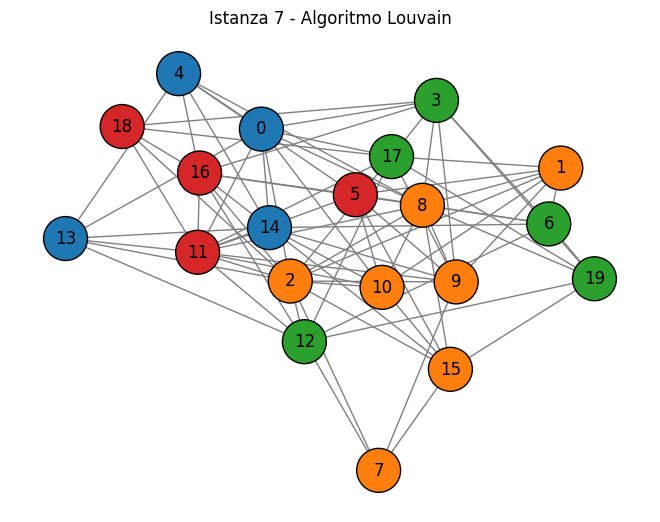

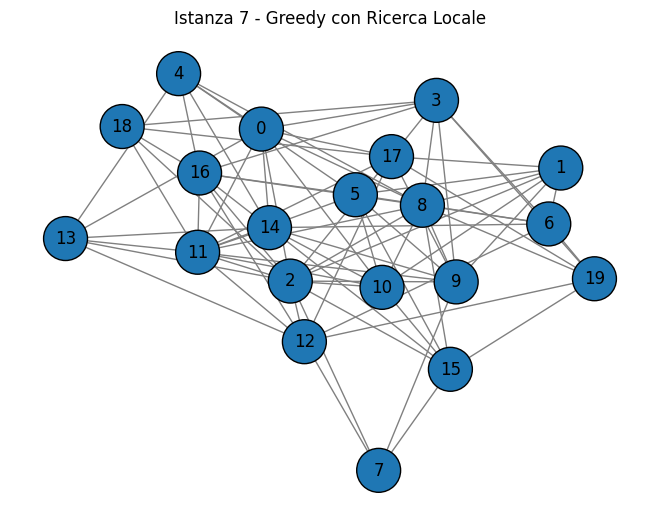

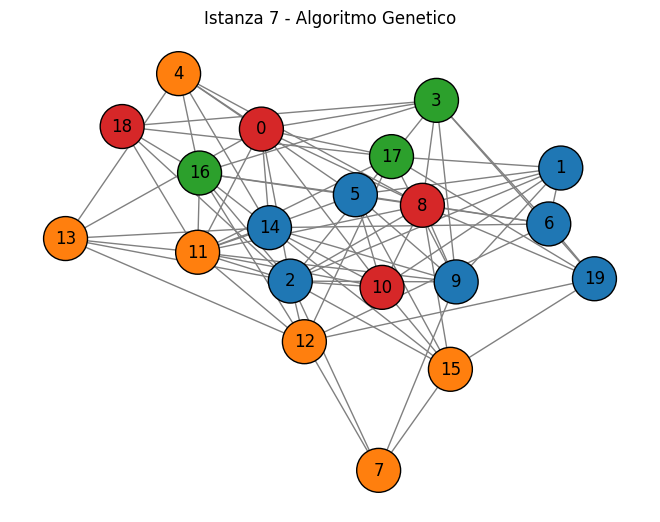

Istanza 7:
  - Tempo di esecuzione Louvain: 0.0017 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.2390 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.8040 secondi


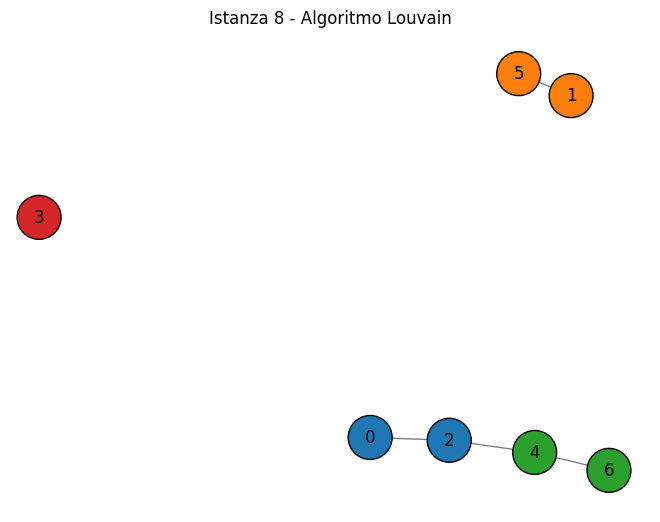

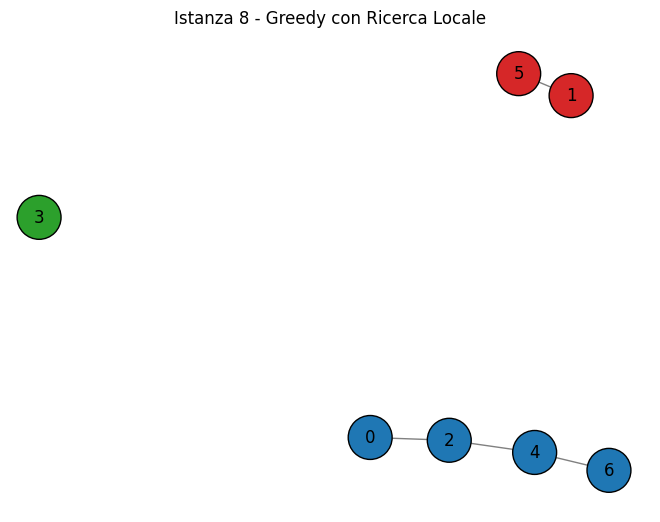

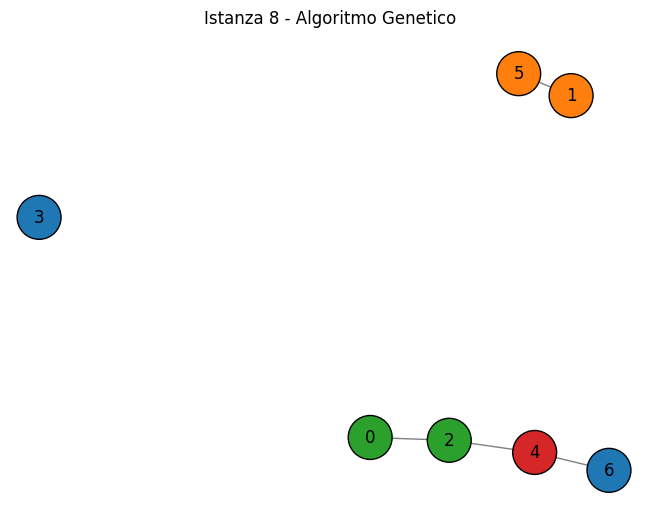

Istanza 8:
  - Tempo di esecuzione Louvain: 0.0005 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0018 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.6369 secondi


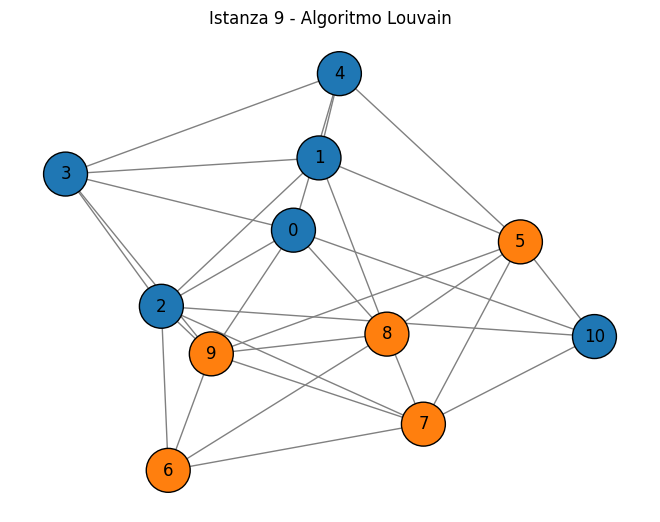

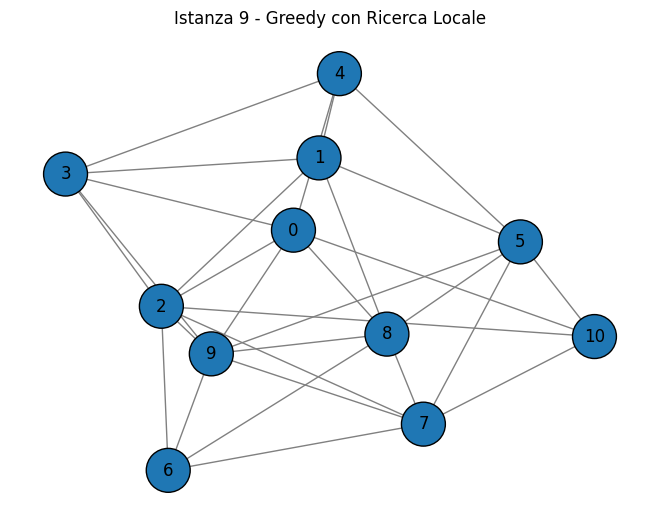

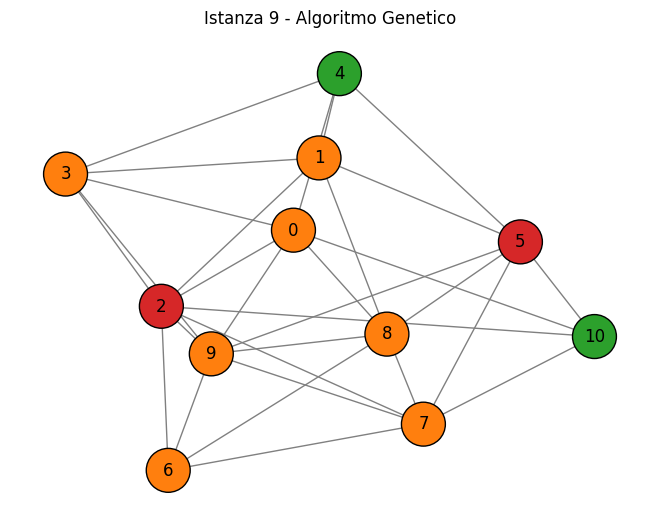

Istanza 9:
  - Tempo di esecuzione Louvain: 0.0011 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0148 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7069 secondi


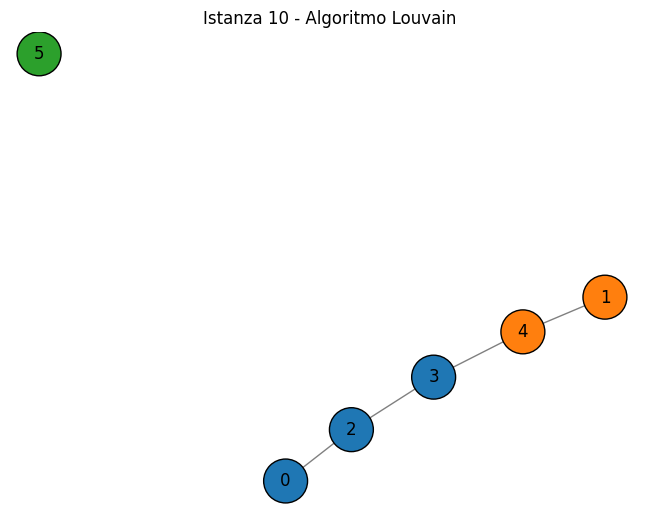

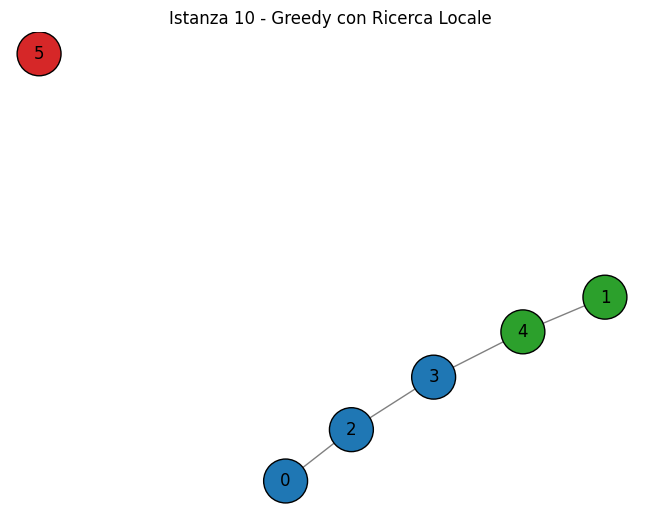

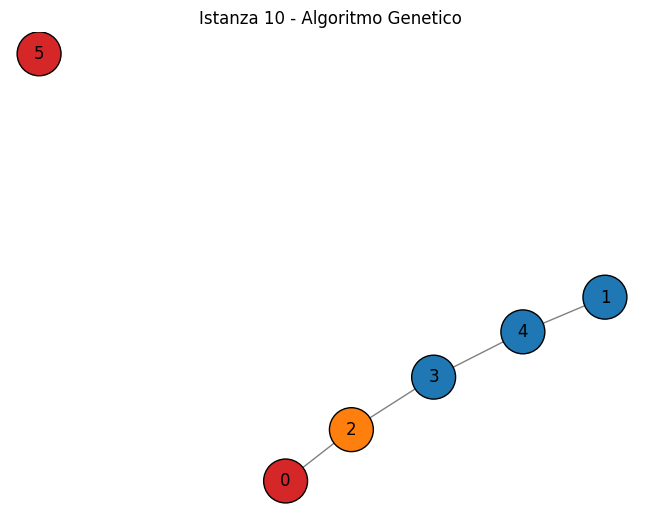

Istanza 10:
  - Tempo di esecuzione Louvain: 0.0004 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0008 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.6754 secondi


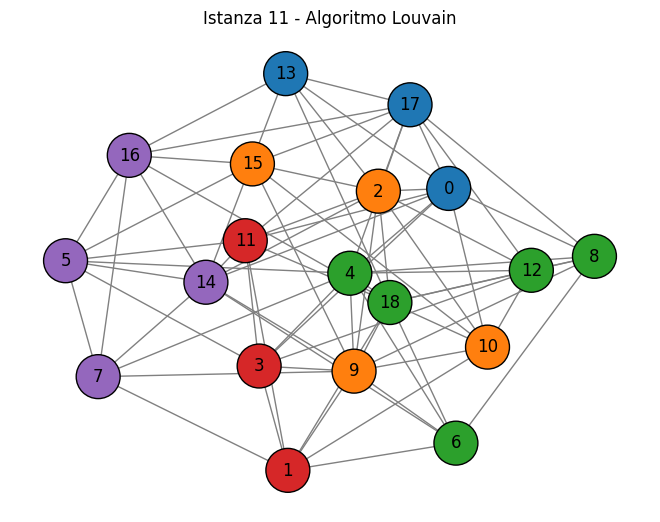

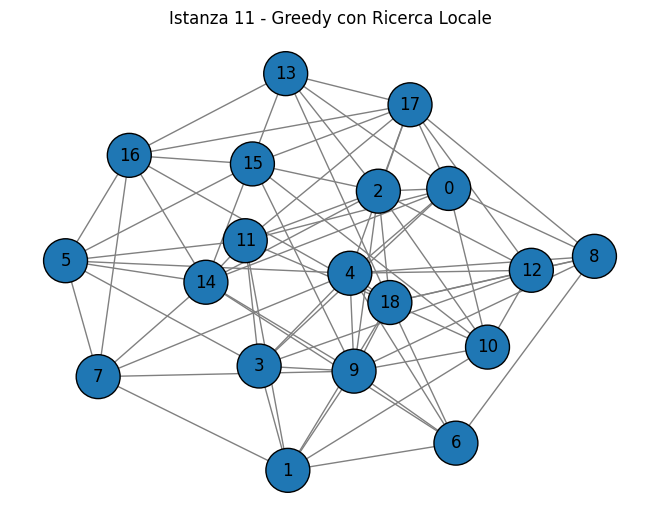

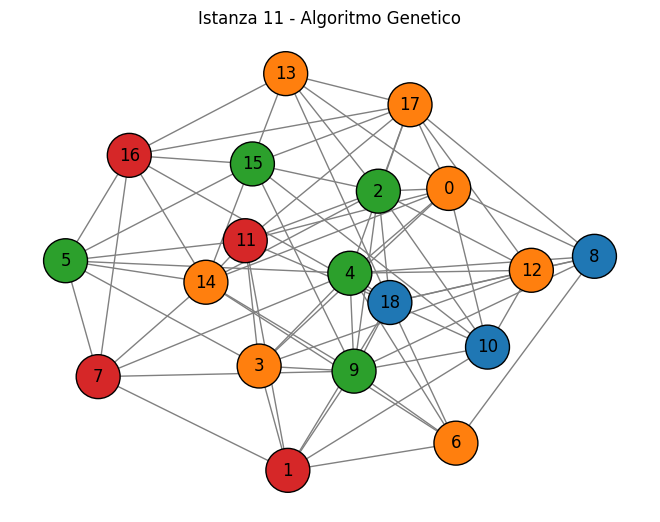

Istanza 11:
  - Tempo di esecuzione Louvain: 0.0013 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.2108 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7453 secondi


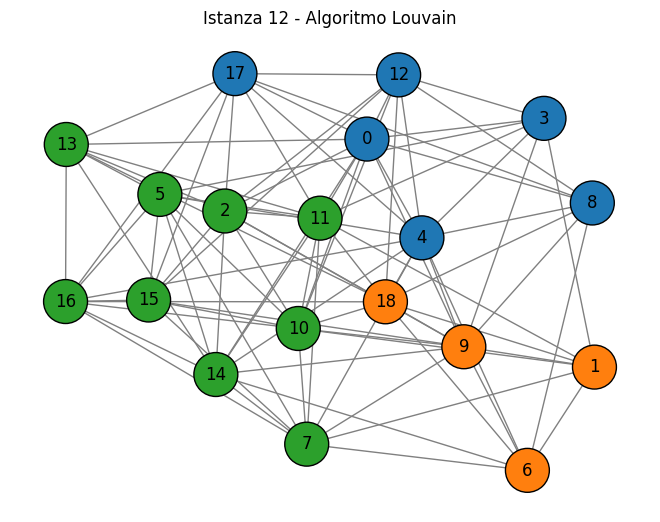

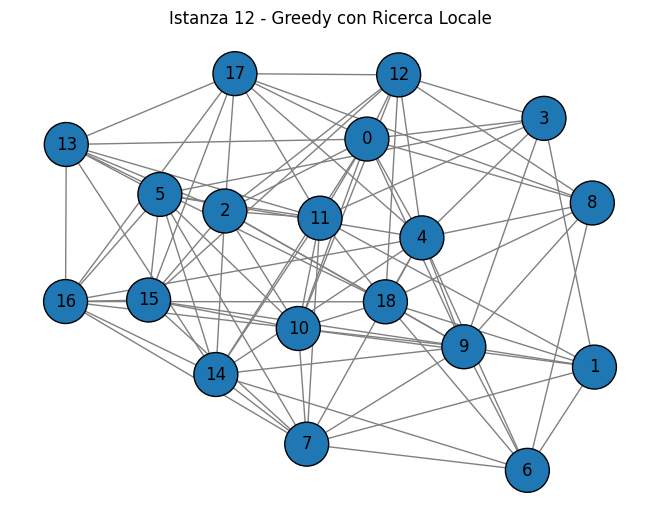

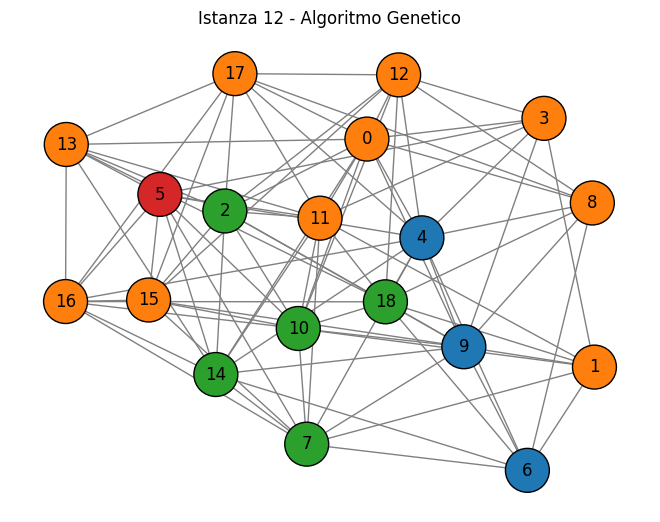

Istanza 12:
  - Tempo di esecuzione Louvain: 0.0022 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.2412 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7880 secondi


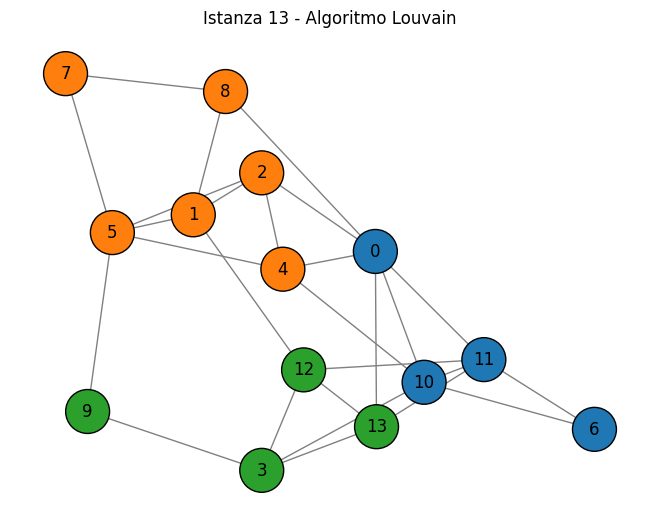

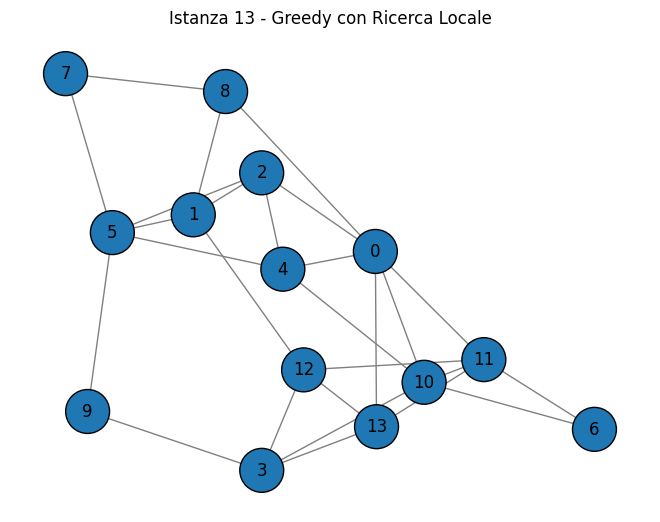

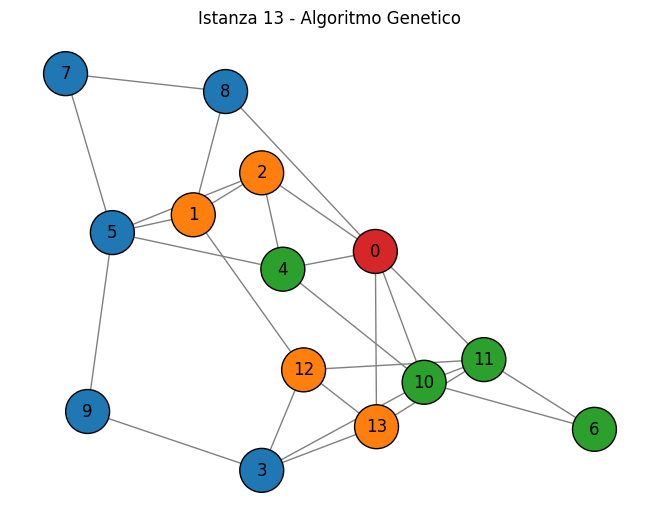

Istanza 13:
  - Tempo di esecuzione Louvain: 0.0010 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0289 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7279 secondi


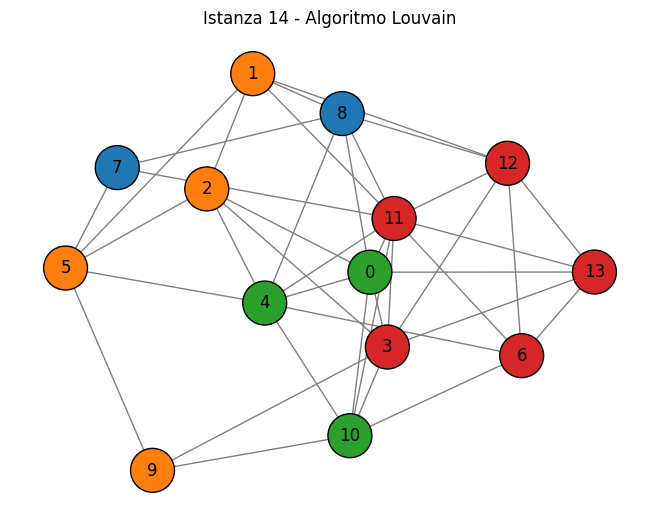

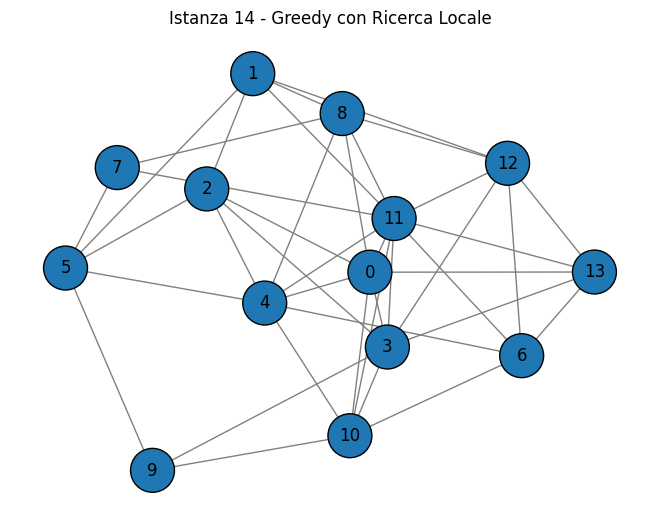

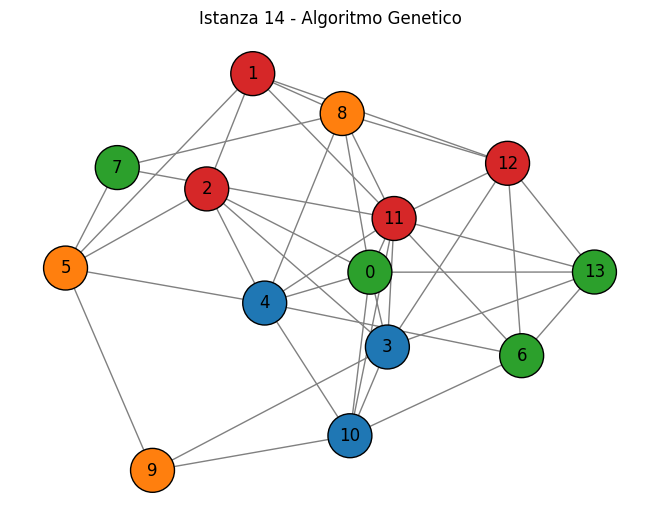

Istanza 14:
  - Tempo di esecuzione Louvain: 0.0009 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0402 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7325 secondi


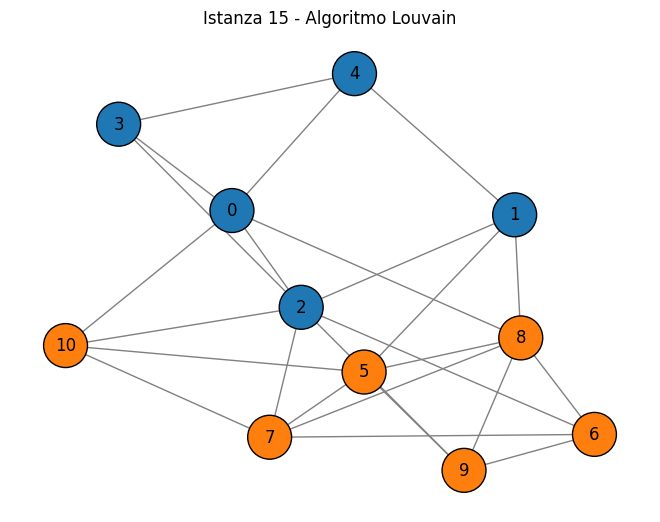

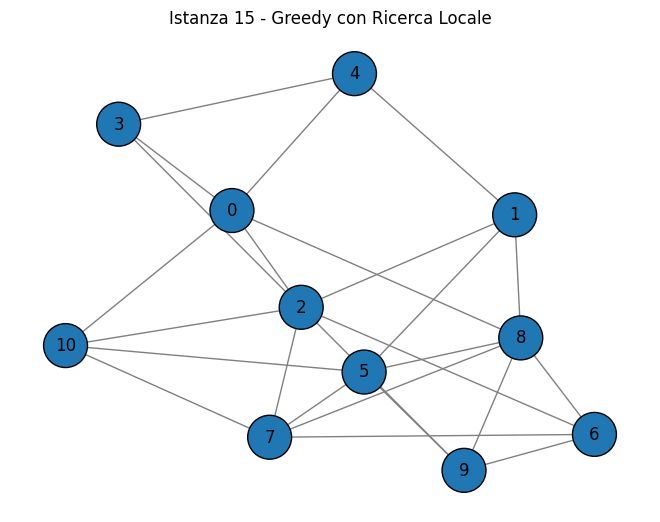

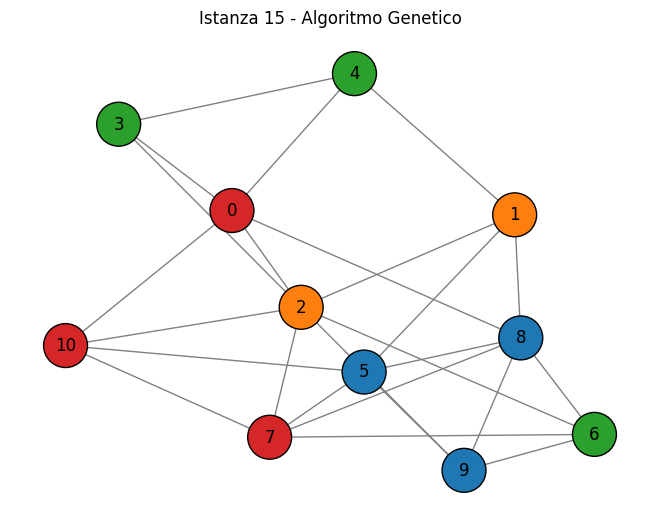

Istanza 15:
  - Tempo di esecuzione Louvain: 0.0011 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0158 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.6827 secondi


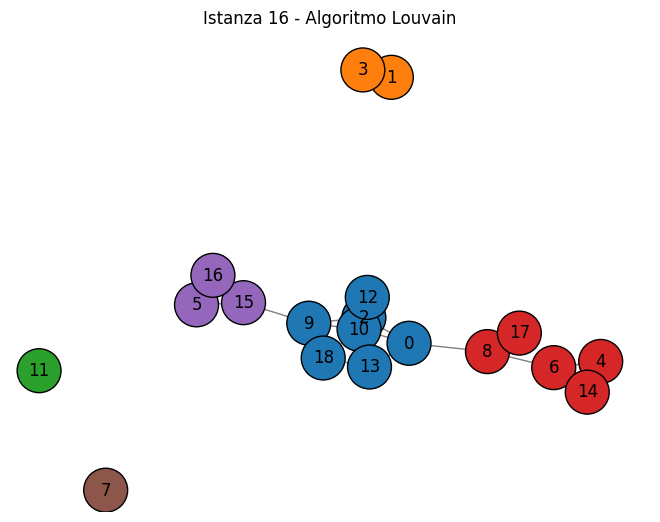

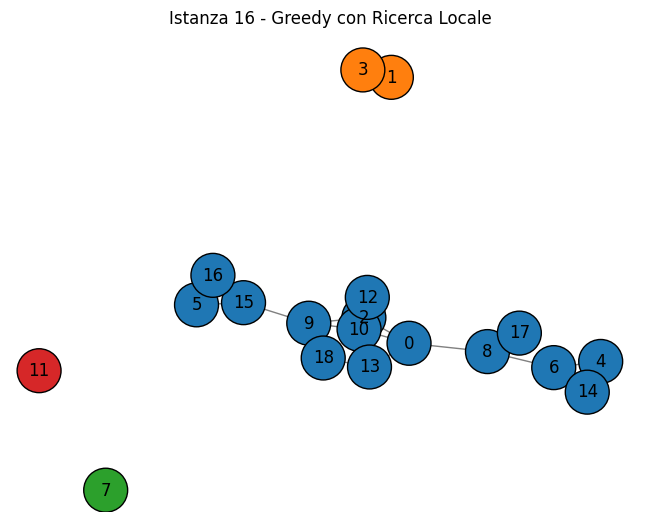

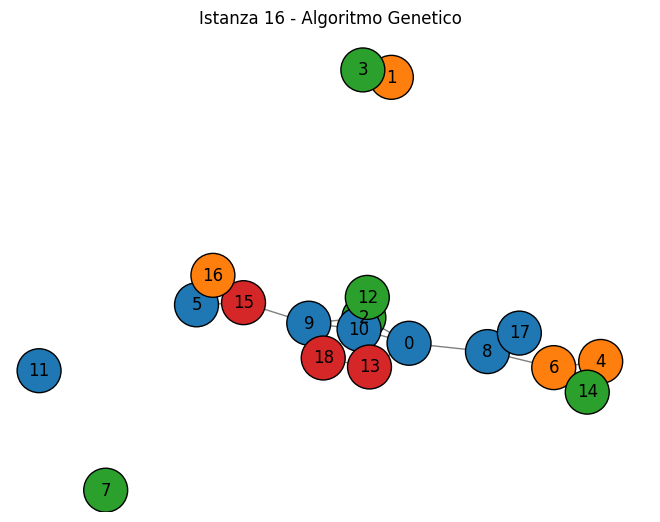

Istanza 16:
  - Tempo di esecuzione Louvain: 0.0019 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0531 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7060 secondi


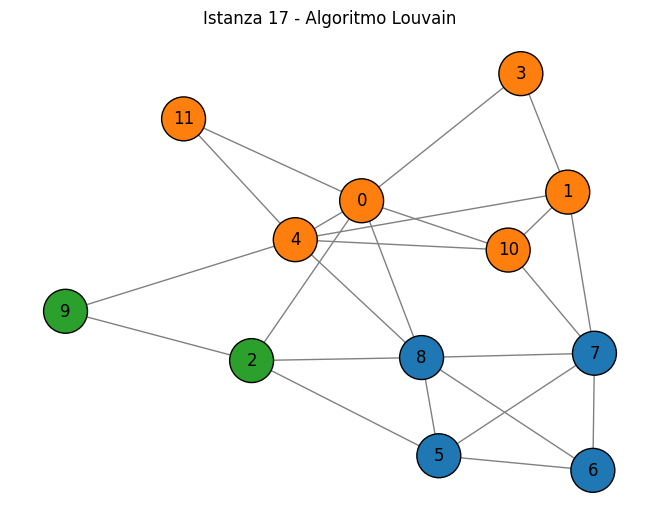

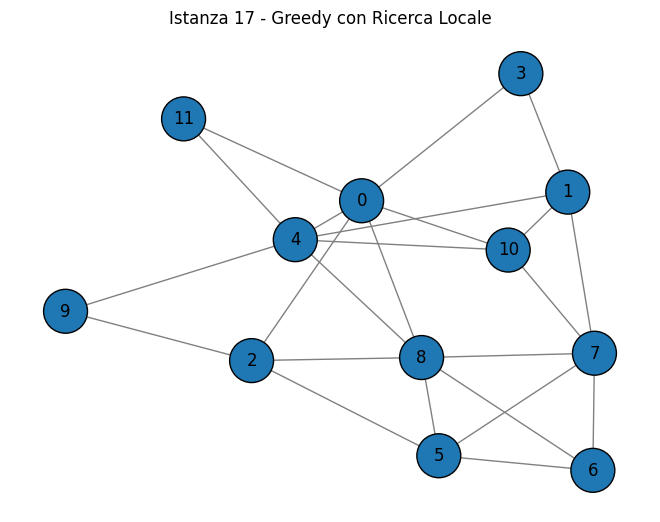

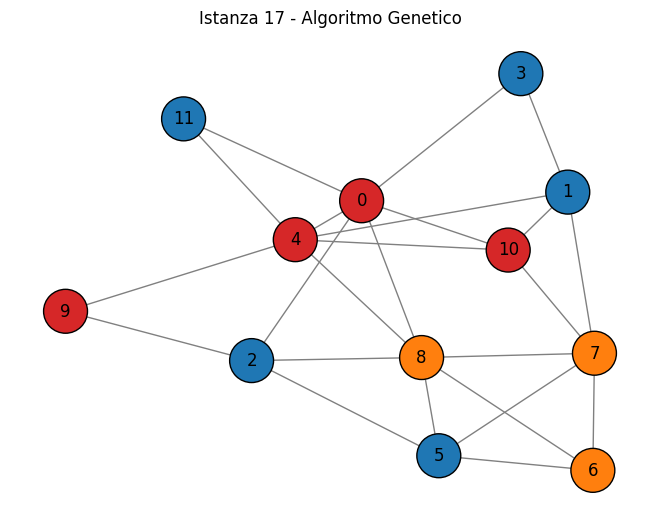

Istanza 17:
  - Tempo di esecuzione Louvain: 0.0009 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0202 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7230 secondi


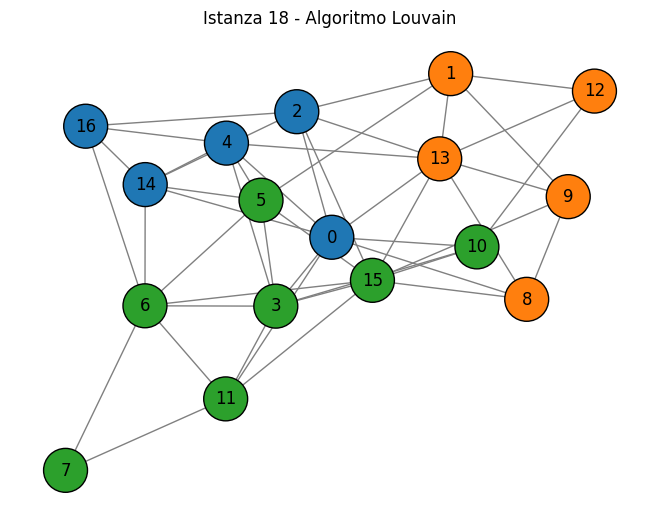

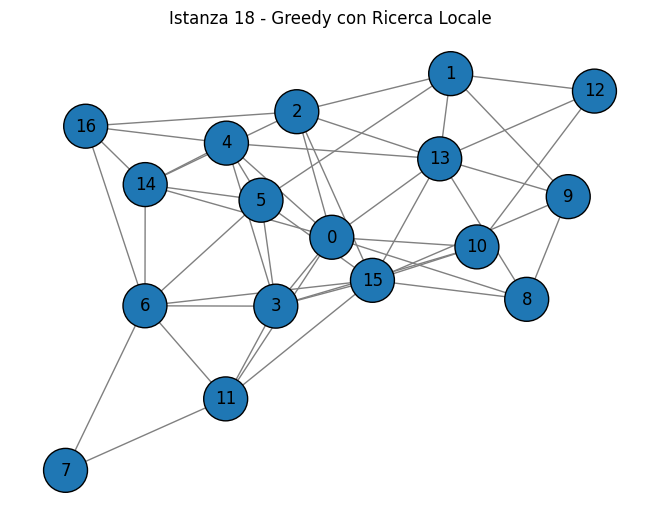

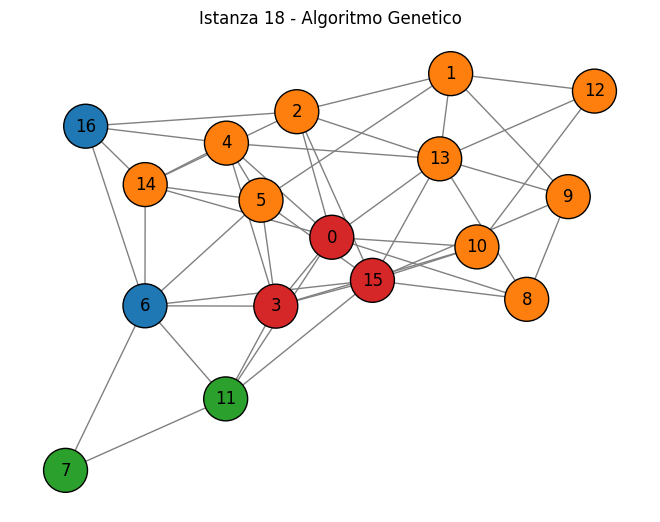

Istanza 18:
  - Tempo di esecuzione Louvain: 0.0012 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.1105 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7333 secondi


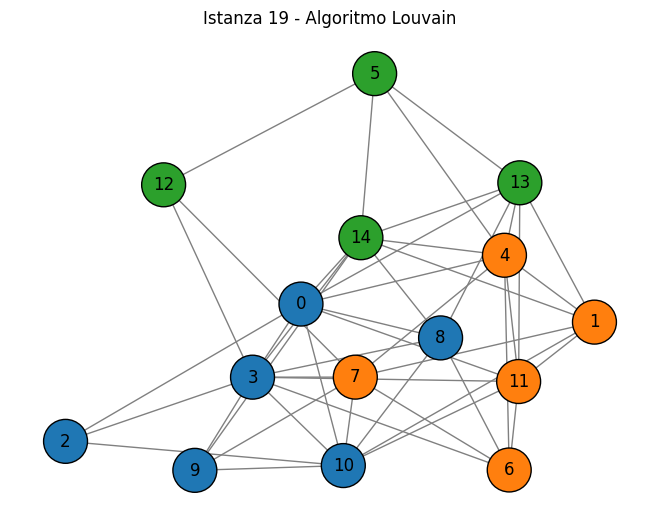

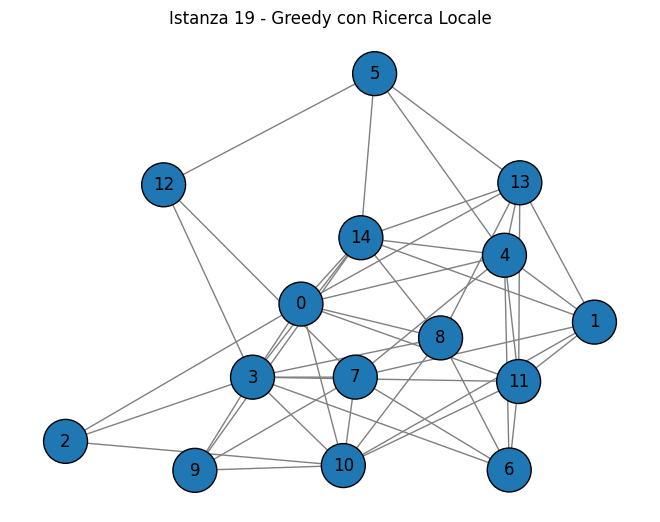

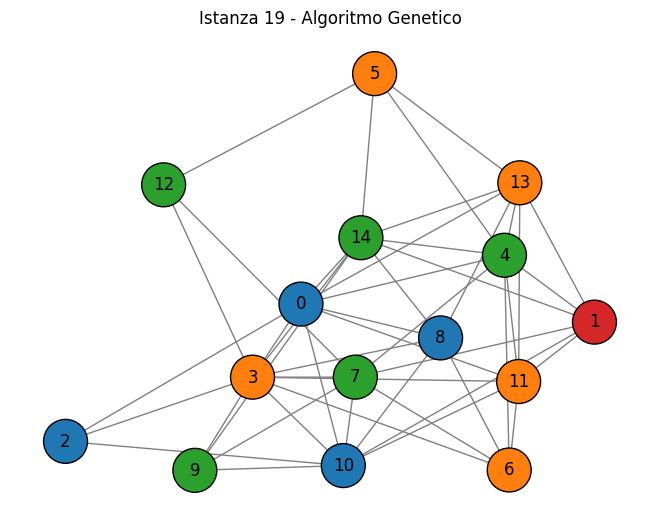

Istanza 19:
  - Tempo di esecuzione Louvain: 0.0015 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0601 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.7135 secondi


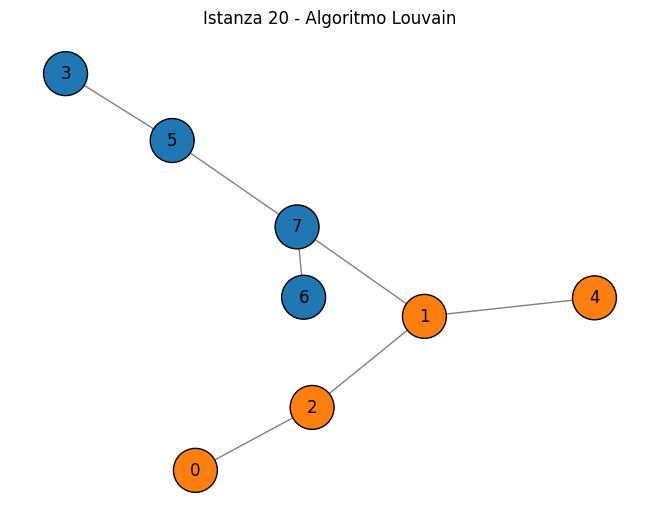

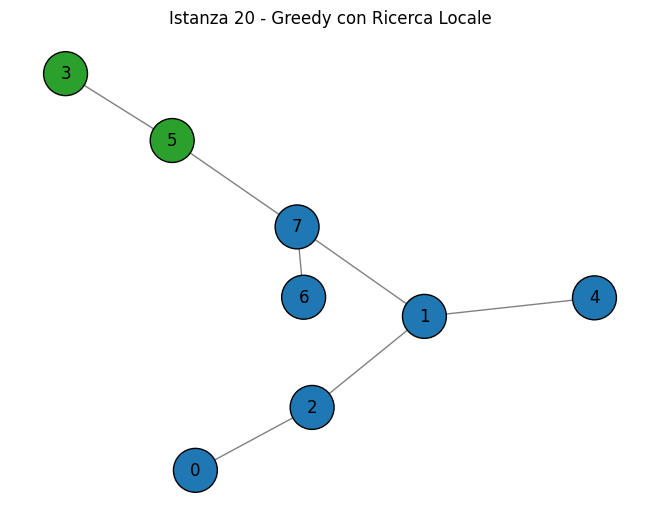

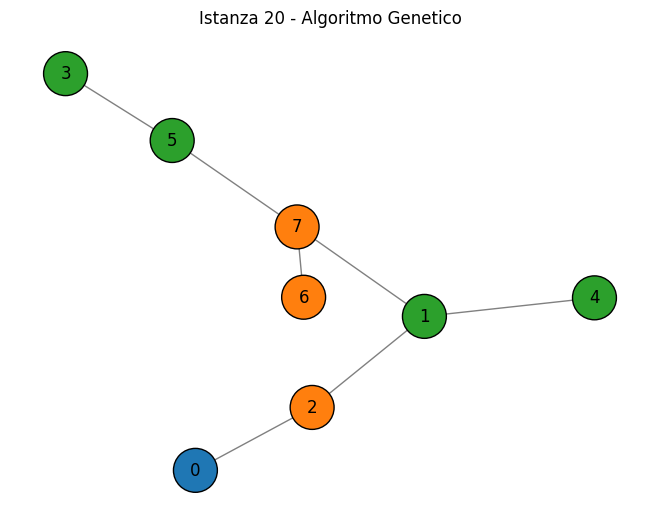

Istanza 20:
  - Tempo di esecuzione Louvain: 0.0006 secondi
  - Tempo di esecuzione Greedy con Ricerca Locale: 0.0028 secondi
  - Tempo di esecuzione Algoritmo Genetico: 0.6854 secondi


In [138]:
def genera_istanze(n_istanze=20):
    istanze = []
    for _ in range(n_istanze):
        n = random.randint(5, 20)
        p = random.uniform(0.05, 0.55)
        G = nx.erdos_renyi_graph(n, p, seed=42)
        istanze.append(G)
    return istanze

def main():
    istanze_di_test = genera_istanze()

    for idx, grafo in enumerate(istanze_di_test):

        # Esegui l'algoritmo Louvain
        start_time = time.time()
        partition = community_louvain.best_partition(grafo)
        end_time_louvain = time.time() - start_time
        clusters_louvain = [ [node for node, part in partition.items() if part == i] for i in set(partition.values()) ]

        # Salva le immagini dell'output per Louvain
        plot_graph(grafo, f"Istanza {idx+1} - Algoritmo Louvain", 
                   filename=f'output_istanza_{idx+1}_louvain.png', colors=clusters_louvain)

        # Esegui Greedy con Ricerca Locale
        start_time = time.time()
        clusters_greedy = divide_into_clusters_greedy(grafo, 4)  # Assumo un valore arbitrario di k=4 per semplicità
        clusters_ricerca_locale_su_greedy = ricerca_locale(grafo, clusters_greedy)
        end_time_greedy_ricerca_locale = time.time() - start_time

        # Salva le immagini dell'output per Greedy con Ricerca Locale
        plot_graph(grafo, f"Istanza {idx+1} - Greedy con Ricerca Locale", 
                   filename=f'output_istanza_{idx+1}_greedy_ricerca_locale.png', colors=clusters_ricerca_locale_su_greedy)

        # Esegui l'algoritmo genetico
        start_time = time.time()
        clusters_genetico = genetic_algorithm(grafo,k=4)
        end_time_genetico = time.time() - start_time

        # Salva le immagini dell'output per l'algoritmo genetico
        plot_graph(grafo, f"Istanza {idx+1} - Algoritmo Genetico", 
                   filename=f'output_istanza_{idx+1}_genetico.png', colors=clusters_genetico)

        # Stampa i risultati 
        print(f"Istanza {idx+1}:")
        print(f"  - Tempo di esecuzione Louvain: {end_time_louvain:.4f} secondi")
        print(f"  - Tempo di esecuzione Greedy con Ricerca Locale: {end_time_greedy_ricerca_locale:.4f} secondi")
        print(f"  - Tempo di esecuzione Algoritmo Genetico: {end_time_genetico:.4f} secondi")

if __name__ == "__main__":
    main()
